# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import re

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [6]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

`1.` What is the distribution of how many articles a user interacts with in the dataset?  

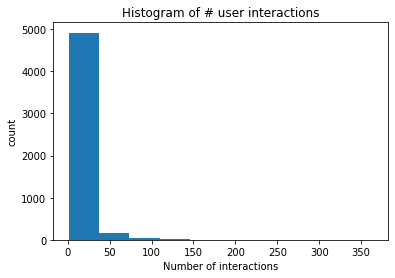

In [12]:
interactions_per_user = df.email.value_counts(sort=False).values

plt.hist(interactions_per_user)
plt.title('Histogram of # user interactions')
plt.xlabel('Number of interactions')
plt.ylabel('count');

As there are many outliers, it's a good ideia to use the **median** instead of the mean.

In [13]:
median_val = np.median(interactions_per_user)
print("The median # of interactions a user makes is {}.".format(median_val))

The median # of interactions a user makes is 3.0.


In [14]:
max_views_by_user = max(interactions_per_user)

print(f"The max # of interactions a user made is {max_views_by_user}.")

The max # of interactions a user made is 364.


`2.` Exploring and removing duplicate articles from the **df_content** dataframe.  

In [6]:
df_content.article_id.value_counts()

221     2
232     2
577     2
398     2
50      2
356     1
355     1
354     1
353     1
345     1
352     1
351     1
350     1
349     1
348     1
357     1
347     1
346     1
1050    1
344     1
359     1
343     1
342     1
341     1
340     1
339     1
338     1
337     1
336     1
335     1
       ..
706     1
719     1
718     1
717     1
716     1
715     1
714     1
713     1
712     1
711     1
710     1
709     1
708     1
707     1
705     1
691     1
704     1
703     1
702     1
701     1
700     1
699     1
698     1
697     1
696     1
695     1
694     1
693     1
692     1
0       1
Name: article_id, Length: 1051, dtype: int64

As we could see, there are 5 duplicated articles. Let's check how some of them look like: 

In [7]:
df_content[df_content.article_id == 577]

,doc_body,doc_description,doc_full_name,doc_status,article_id
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [8]:
df_content[df_content.article_id == 232]

,doc_body,doc_description,doc_full_name,doc_status,article_id
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


As we can see, the articles look the same even though they are duplicated, so there is no problem in dropping them. To drop, I'll consider only the `article_id` column.

In [15]:
df_content.drop_duplicates(subset='article_id', inplace=True)

`3.` In the cells below I'll find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [16]:
unique_articles = len(df.article_id.unique()) # The number of unique articles that have at least one interaction
total_articles = df_content.article_id.nunique() # The number of unique articles on the IBM platform
unique_users = df.email.nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

In [17]:
print('There are {} articles that have at least one interaction and the plataform sums a total of {} interactions. '
      'The IBM plataform has a total of {} articles and {} users. '
      .format(unique_articles, user_article_interactions, total_articles, unique_users))

There are 714 articles that have at least one interaction and the plataform sums a total of 45993 interactions. The IBM plataform has a total of 1051 articles and 5148 users. 


`4.` The cells below will find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [18]:
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [19]:
most_viewed_article_id = df.article_id.value_counts().keys()[0]
# The most viewed article in the dataset was viewed how many times?
max_views = df.article_id.value_counts().values[0] 

In [20]:
print('Article {} is the most viewed with {} views.'.format(most_viewed_article_id, max_views))

Article 1429.0 is the most viewed with 937 views.


In [21]:
# this cell maps the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

We don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` The function below returns the **n** top articles ordered with most interactions as the top.

In [22]:
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    '''
    top_articles = list(df.article_id.value_counts().keys())[:n]
    
    return top_articles # Return the top article ids


def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = get_top_article_ids(n)
    
    top_articles_titles = []
    for idx in top_articles:
        top_articles_titles.append(df[df.article_id == idx].title.values[0])

    return top_articles_titles

In [23]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` The function below reformats the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

In [24]:
# remove duplicates

drop_df = df.drop_duplicates()

In [25]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    user_ids = df.user_id.unique()
    articles_ids = df.article_id.unique() 
    
    user_item = pd.DataFrame(data=0, index=user_ids, columns=articles_ids)
    for row in df.itertuples():
        user_item.loc[row.user_id, row.article_id] += 1
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(drop_df)

`2.` The function below should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result will not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

In [28]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity_matrix = np.dot(user_item, user_item.transpose())
    # sort by similarity
    sim_users = list(similarity_matrix[user_id - 1, :].argsort())
    sim_users.reverse()
    
    # create list of just the ids
    most_similar_users = list(np.array(sim_users) + 1)
    # remove the own user's id
    most_similar_users.remove(user_id)
    
    # return a list of the users in order from most to least similar
    return most_similar_users 

In [29]:
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now we have a function that provides the most similar users to each user, we will want to use these users to find articles we can recommend.

In [30]:
df['article_id'] = df['article_id'].astype(float)
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [31]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = []
    for idx in article_ids:
        article_names.append(df[df.article_id == float(idx)].title.values[0])
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = list(user_item.columns[user_item.loc[user_id, :] > 0])
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names 


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''

    similar_users = find_similar_users(user_id)
    user_articles, _ = get_user_articles(user_id)
    
    recs = []
    for user in similar_users:
        rec_articles, _ = get_user_articles(user)
        
        for article in rec_articles:
            if (article not in user_articles) and (article not in recs): 
                recs.append(article)
            
        if len(recs) >= m:
            recs = recs[:m]
            break
        
    return recs 

In [32]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['healthcare python streaming application demo',
 'ml optimization using cognitive assistant',
 'deploy your python model as a restful api',
 'visualize data with the matplotlib library',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'the unit commitment problem',
 'timeseries data analysis of iot events by using jupyter notebook',
 'the nurse assignment problem',
 'dsx: hybrid mode',
 'predicting churn with the spss random tree algorithm']

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be what would be obtained from the **top_articles** function we wrote earlier.

In [33]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number 
                    of interactions where highest of each is higher in the dataframe
     
    '''
    interactions_count = df.user_id.value_counts(sort=False)
    ids = interactions_count.keys()
    count = interactions_count.values
    neighbors_df = pd.DataFrame(count, index=ids, columns=['num_interactions'])
    neighbors_df.index.name = 'neighbor_id'
    neighbors_df = neighbors_df[neighbors_df.index != user_id]

    similar_users = find_similar_users(user_id)
    similar_users.reverse()
    
    similarity = []
    for user in neighbors_df.index:
        similarity.append(similar_users.index(user))
    
    similarity = np.array(similarity)
    
    scaler = MinMaxScaler((0, 10))
    neighbors_df['similarity'] = scaler.fit_transform(similarity.reshape(-1, 1))
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], 
                             inplace=True, ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    
    articles_rank = df.article_id.value_counts()
    similar_users = get_top_sorted_users(user_id)
    neighbors_rank = list(similar_users.index)
    user_articles = get_user_articles(user_id)
    
    recs = []
    for user in neighbors_rank:
        rec_articles, _ = get_user_articles(user)
        rec_articles.sort(reverse=True, key=lambda article_id: articles_rank[article_id])
        
        for article in rec_articles:
            if (article not in user_articles) and (article not in recs): 
                recs.append(article)
            
        if len(recs) >= m:
            recs = recs[:m]
            break
        
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [34]:
# the bigger the similarity the better
# gets similar users for user 1
get_top_sorted_users(1).head(10)

,num_interactions,similarity
neighbor_id,,
3933,45,10.000000
23,364,9.998057
3782,363,9.996114
203,160,9.994171
4459,158,9.992228
131,145,9.990286
3870,144,9.988343
46,63,9.986400
4201,61,9.984457


In [35]:
rec_ids, rec_names = user_user_recs_part2(20, 10)

print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1162.0, 1304.0, 43.0, 1351.0]

The top 10 recommendations for user 20 are the following article names:
['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'deep learning with tensorflow course by big data university', 'model bike sharing data with spss']


`5.` With a new user it isn't possible to use user similarity, we would use the `get_top_articles` function that takes in consideration only existing articles. Another possible way is  a function that implements content-based reccomendation, this would be possible by asking the user which topics he finds interesting or relevant. 

In [36]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provides a list of the top 10 article ids I would recommend 
new_user_recs = get_top_article_ids(10)
print(new_user_recs)

[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  We might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` The function body below creates a content based recommender considering a search query given by the user.  

In [39]:
import re

In [40]:
def make_content_recs(search_terms, n):
    '''
    Makes n recommendations from top articles considering search query given by the user.
    
    INPUT:
        search_terms : str
            user search query 
        n : int
            number of recommendations to make
    OUTPUT:
        recs : list
            list with recommended articles titles  
    '''
    
    tokens = search_terms.lower().split()
    articles_titles = get_top_articles(100)
    
    title_fitness = []
    for title in articles_titles:
        count = 0
        #removing special characters
        split = re.sub('[^A-Za-z0-9]', ' ', title).split()
        
        for token in tokens:
            if token in split:
                count += 1
                
        title_fitness.append(count)
        
    sorted_titles = sorted(articles_titles, key=lambda x: title_fitness[articles_titles.index(x)], reverse=True)
    
    return sorted_titles[:n]

`2.` The recommender engine above works with a user search query, it simply counts similar words between the query and the titles of the top articles, in the end, the titles are ordered based on the similarity between the query and article titles. One possible upgrade could be using NLP techniques as stemming and lemmatization, or at a more advanced level, using word embeddings to calculate the similarity between one query and the article titles.

`3.` Making 10 recommendations for query ```deep learning 101```

In [44]:
make_content_recs('deep learning 101', n=10)

['use deep learning for image classification',
 'deep learning with tensorflow course by big data university',
 'learn tensorflow and deep learning together and now!',
 'deep learning with data science experience',
 'using deep learning with keras to predict customer churn',
 'deep learning from scratch i: computational graphs',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'classify tumors with machine learning',
 'movie recommender system with spark machine learning',
 'putting a human face on machine learning']

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, we will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` We already created a **user_item** matrix above in **question 1** of **Part III** above.  Let's first have a glimpse of what the matrix looks like.

In [45]:
user_item.head()

,1430.0,1314.0,1429.0,1338.0,1276.0,1432.0,593.0,1185.0,993.0,14.0,...,1135.0,881.0,183.0,655.0,1233.0,1156.0,555.0,708.0,575.0,972.0
1,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Where each line represents a user and each column represents an article. The values indicate if user `n` interacted with article `m`.  

`2.` In this situation, we can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix. 

In [46]:
u, s, vt = np.linalg.svd(user_item)

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, we can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  The cell below gives us an idea of how the accuracy improves as we increase the number of latent features.

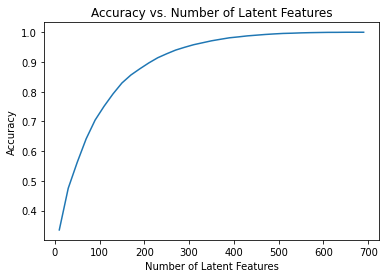

In [48]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Using the code from question 3 we can understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [49]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = list(user_item_test.index)
    test_arts = list(user_item_test.columns)
        
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [50]:
train_idx = set(user_item_train.index)
train_arts = set(user_item_train.columns)
s_test_idx = set(test_idx)
s_test_arts = set(test_arts)

In [51]:
# number of users in both training and test data

len(train_idx.intersection(s_test_idx))

20

In [52]:
# number of articles in both training and test data

len(train_arts.intersection(s_test_arts))

574

In [53]:
# number of articles in test data

len(test_arts)

574

`5.` Now we use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [55]:
user_item_train.head()

,1430.0,1314.0,1429.0,1338.0,1276.0,1432.0,593.0,1185.0,993.0,14.0,...,1135.0,881.0,183.0,655.0,1233.0,1156.0,555.0,708.0,575.0,972.0
1,2,0,1,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,25,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,3,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
user_item_test.head()

,1053.0,1314.0,1424.0,1176.0,58.0,14.0,33.0,103.0,1163.0,485.0,...,862.0,1187.0,1415.0,1414.0,339.0,857.0,499.0,460.0,367.0,588.0
4487,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4488,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4489,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4490,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4491,0,2,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [57]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [58]:
train_test_users = list(train_idx.intersection(s_test_idx))
train_test_arts = list(train_arts.intersection(s_test_arts))

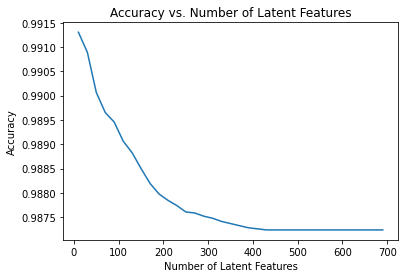

In [59]:
num_latent_feats = np.arange(10, 700 + 10, 20)
sum_errs = []
users_idx = np.array(train_test_users) - 1
arts_idx = [list(user_item_train.columns).index(art) for art in train_test_arts]
test_subset = user_item_test.loc[train_test_users, train_test_arts]

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]

    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    user_lines = user_item_est[users_idx, :]
    preds = user_lines[:, arts_idx]
    
    # compute error for each prediction to actual value
    diffs = np.subtract(test_subset, preds)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Unfortunately, more features didn't mean a higher accuracy.  But accuracy in this case can't be used as a fair metric to evaluate the model as there are only 20 users who co-existed between the training and testing datasets. 